In [122]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [123]:
p = Project.objects.get(pk=127)

docs = Doc.objects.filter(docproject__project=p, content__iregex='\w').values_list('pk', flat=True)

docs = docs.exclude(query__in=[6819,6820,7135,7242])

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query__project=p, 
    relevant__gt=0
).values_list('doc__pk', flat=True))

tosee = set(DocOwnership.objects.filter(
    query__project=p,
    relevant=0
).values_list('doc__pk',flat=True))

toseetags = DocOwnership.objects.filter(
    query__project=p,
    relevant=0
).values('tag__title').annotate(
    n = Count('pk')
)

tosee = tosee & set(docs)

print(len(tosee))

seen = seen & set(docs)

print(len(seen))


#seen = seen | tosee

print(len(seen))

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

30850
1359
2775
2775


2775

In [124]:
seen_docs.filter(
    docproject__project=p
).values('docproject__relevant').annotate(
    n = Count('pk')
)

<QuerySet [{'docproject__relevant': 1, 'n': 616}, {'docproject__relevant': 2, 'n': 1892}, {'docproject__relevant': 3, 'n': 95}, {'docproject__relevant': 4, 'n': 172}]>

In [125]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(28075, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,214,Coal is used extensively around the world as a...,Corrosion testing of advanced-ultrasupercritic...,None,None,0,0
1,582,Co-combustion of coal and biomass is an effect...,Particulate matter formation characteristics d...,None,None,0,0
2,846,"Based on VGB, IEA - statistics, demand for new...",CFB technology provides solutions to combat cl...,None,None,0,0
3,1400,Understanding of fundamental aspects of coal m...,Optimization of superheated steam drying to re...,None,None,0,0
4,1713,We compared the greenhouse gas (GHG) emissions...,Reductions in greenhouse gas emissions by usin...,Soil liquefaction; Greenhouse gas balance; Log...,"[Forestry; Materials Science, Paper & Wood]",0,0


In [ ]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])
    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

In [ ]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

In [ ]:
duplicateRowsDF = df[df['title'].isin(df[df.duplicated(['title'])].title)]
duplicateRowsDF.shape

In [ ]:
duplicateRowsDF.sort_values('title')

In [99]:

def doc_merge(request,pid: int, d1: int, d2: int) -> str:
    """Merge duplicated documents

Ajax function

Adds all the info from the given project from the document 2 to document 1,
removing it from all queries

Args:
    * pid (int): Project ID
    * d1 (int): ID of Document to keep
    * d2 (int): ID of Document to throw

Todos:
    * Remove docproject object?

..

    """
    p = Project.objects.get(pk=pid)
    keep = Doc.objects.get(pk=d1)
    throw = Doc.objects.get(pk=d2)
    dup, created = Duplicate.objects.get_or_create(
        original = keep,
        copy = throw,
        project = p,
        user = request.user
    )
    if keep.alternative_titles is None:
        keep.alternative_titles = [throw.title]
    elif throw.title not in keep.alternative_titles:
        keep.alternative_titles.append(throw.title)
    for q in throw.query.filter(project=p):
        throw.query.remove(q)
        keep.query.add(q)
        q.r_count = q.doc_set.count()
        q.save()
    for t in throw.tag.filter(query__project=p):
        throw.tag.remove(t)
        keep.tag.add(t)
        t.update_tag()
    models = [
        StudyEffect,DocMetaCoding,DocProject,
        Exclusion, DocUserCat, DocCat,
        DocPar, DocOwnership
        ## Need to filter by projectt!!!
    ]
    print("DOCOWNERSHIP")
    
    for x in models:
        if hasattr(x,'project'):
            if hasattr(x, 'query'):
                insts = x.objects.filter(doc=throw, query__project=p) | x.objects.filter(doc=throw, project=p)
            else:
                insts = x.objects.filter(doc=throw,project=p)
        elif hasattr(x,'category'):
            insts = x.objects.filter(doc=throw,category__project=p)
        else:
            insts = []
            print(x)
        for i in insts:
            print(i)
            ignore_fields = ["_state","doc__id","doc_id","doc","id"]
            instance = {k:v for k,v in i.__dict__.items() if k not in ignore_fields}
            instance["doc"] = keep
            try:
                new_int, created = x.objects.get_or_create(**instance)
            except django.db.utils.IntegrityError:
                print("already exists")
            i.delete()
    # Return a message saying "merged"
    return "merged"

In [101]:
from scoping.views import doc_merge

class Request:
    def __init__(self):
        self.user = User.objects.get(pk=1)
    
request = Request()
print(request.user)

for name, group in duplicateRowsDF.groupby('title'):
    docs = Doc.objects.filter(title=name)
    print(name)
    try:
        d1 = docs.get(UT__UT__contains="WOS:")
    except:
        d1 = None
    if d1 is None:
        break
        
    for d2 in docs.exclude(pk=d1.pk):
        doc_merge(request, 127, d1.id, d2.id)
            


galm
An experimental study on oxidizer treatment used to improve the seepage capacity of coal reservoirs


In [ ]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
#pred_index = pd.Index(random.sample(list(unseen_index),5000))

k = math.ceil(len(seen_index)*0.8)
train_index = pd.Index(random.sample(list(seen_index),k))

print(seen_index)
print(train_index)

#experiment_index = pd.Index(set(seen_index) | set(pred_index))

test_index = pd.Index([x for x in seen_index if x not in train_index])


In [ ]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5, max_df=0.6, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

y = df['relevant']
vec.fit(df.loc[seen_index,'content'])
ab_X = vec.transform(df['content'])
print(ab_X.shape)

<IPython.core.display.Javascript object>


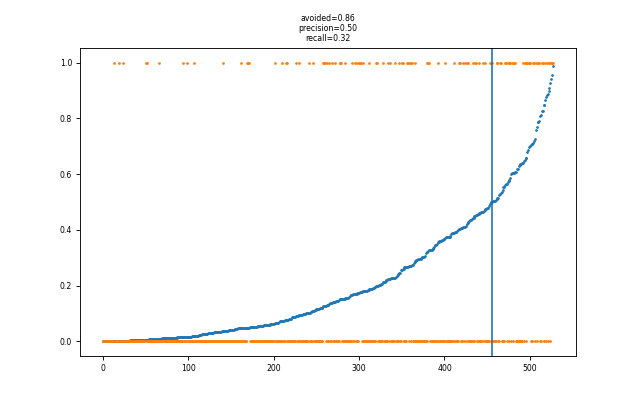

In [108]:
import importlib
importlib.reload(learning_utils)

clf = MultinomialNB(alpha=0.1)
clf.fit(ab_X[train_index],y[train_index])

fig, ax = plt.subplots(figsize=(8,5))
learning_utils.plot_model_accuracy(clf,ab_X[test_index],y[test_index],ax,0.5)

<IPython.core.display.Javascript object>


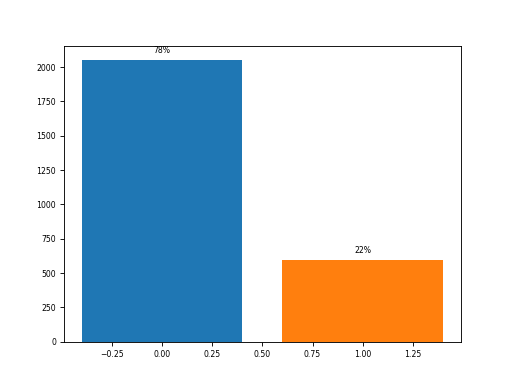

In [109]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

In [114]:
import scoping.utils.learning_utils as lu

models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear', class_weight='balanced', C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

models, df = lu.cross_validate_models(ab_X, y, models, seen_index, n_splits=6, df = df)

1
2
3
4
5
6


<IPython.core.display.Javascript object>


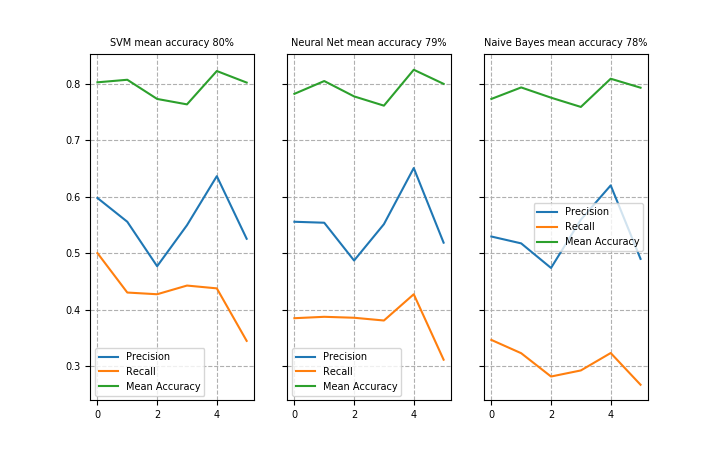

{'title': 'SVM', 'model': SVC(C=5, class_weight='balanced', kernel='linear', probability=True), 'p': [0.5977011494252874, 0.5555555555555556, 0.47674418604651164, 0.5494505494505495, 0.6363636363636364, 0.5254237288135594], 'r': [0.5, 0.43010752688172044, 0.4270833333333333, 0.4424778761061947, 0.4375, 0.34444444444444444], 'f1': [0.5445026178010471, 0.48484848484848486, 0.45054945054945056, 0.4901960784313726, 0.5185185185185185, 0.4161073825503356], 'e': [0.8027210884353742, 0.8072562358276644, 0.7732426303854876, 0.7636363636363637, 0.8227272727272728, 0.8022727272727272], 'i': [1, 2, 3, 4, 5, 6], 'auc': [0.6980712166172106, 0.6690767519466073, 0.6483242753623187, 0.6585478065546264, 0.6838662790697674, 0.6322222222222224], 'tpr': [array([0. , 0.5, 1. ]), array([0.        , 0.43010753, 1.        ]), array([0.        , 0.42708333, 1.        ]), array([0.        , 0.44247788, 1.        ]), array([0.    , 0.4375, 1.    ]), array([0.        , 0.34444444, 1.        ])], 'fpr': [array([0.

In [115]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
for i, model in enumerate(models):
    print(model)
    ax = axs[i]
    ax.plot(model['p'],label="Precision")
    ax.plot(model['r'],label="Recall")
    ax.plot(model['e'],label="Mean Accuracy")
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    ax.legend()
    
plt.show()

In [ ]:
clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear', class_weight='balanced', probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [ ]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

In [ ]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [ ]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=8994)
t1 = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()
#t2 = Tag(
#    title="predicted relevant sample {}_2".format(now),
#    query=q
#)
#t2.save()

tag = t1

users = q.users.all()
uc = len(users)
for i, row in df.sort_values('prediction',ascending=False).head(100).reset_index(drop=True).iterrows():
    for u in users:
        d = Doc.objects.get(id=row['id'])
        d.tag.add(tag)
        #u = users[i % uc]
        do = DocOwnership(
            doc=d,
            user=u,
            query=q,
            tag=tag
        )
        do.save()
    
t1.update_tag()
#t2.update_tag()

In [ ]:
df.to_csv(f'doctables/predictions_{now}.csv',index=False)